In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import metrics,preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,RandomForestRegressor
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [2]:
df =  pd.read_pickle('../data.2021-03-01.scenarioJunction.pkl.gz').drop(['meta_scenario', 'meta_p_red', 'meta_p_blue', 'meta_seed','meta_id'], axis=1, errors="ignore")

In [3]:
df.dropna(axis=1, how='all',inplace=True)

In [4]:
df_red = df[df['action_team'] == 'red'].copy().drop('action_team', axis=1)
df_blue = df[df['action_team'] == 'blue'].copy().drop('action_team', axis=1)
df_red['label'] = df_red['winner'].apply(lambda x: 1 if x == 'red' else -1)
df_blue['label'] = df_blue['winner'].apply(lambda x: 1 if x == 'blue' else -1)

df_new=pd.concat([df_red,df_blue])

df_neg=df_new[df_new['label']==-1]
df_pos=df_new[df_new['label']==1]

df_move=df_new.loc[((df_new['action_type_Move'] == True)|(df_new['action_type_MoveLoadInto'] == True))].copy()
df_attack=df_new.loc[((df_new['action_type_Attack'] == True)| (df_new['action_type_AttackGround'] == True) |(df_new['action_type_AttackRespond'] == True))].copy()
df_pass=df_new.loc[((df_new['action_type_Pass'] == True)| (df_new['action_type_PassFigure'] == True) |(df_new['action_type_PassTeam'] == True) | (df_new['action_type_PassRespond'] == True))].copy()

df_red_move=df_red.loc[((df_red['action_type_Move'] == True)|(df_red['action_type_MoveLoadInto'] == True))].copy()
df_red_attack=df_red.loc[((df_red['action_type_Attack'] == True)| (df_red['action_type_AttackGround'] == True) |(df_red['action_type_AttackRespond'] == True))].copy()
df_red_pass=df_red.loc[((df_red['action_type_Pass'] == True)| (df_red['action_type_PassFigure'] == True) |(df_red['action_type_PassTeam'] == True) | (df_red['action_type_PassRespond'] == True))].copy()

df_blue_move=df_blue.loc[((df_blue['action_type_Move'] == True)|(df_blue['action_type_MoveLoadInto'] == True))].copy()
df_blue_attack=df_blue.loc[((df_blue['action_type_Attack'] == True)| (df_blue['action_type_AttackGround'] == True) |(df_blue['action_type_AttackRespond'] == True))].copy()
df_blue_pass=df_blue.loc[((df_blue['action_type_Pass'] == True)| (df_blue['action_type_PassFigure'] == True) |(df_blue['action_type_PassTeam'] == True) | (df_blue['action_type_PassRespond'] == True))].copy()



def CrossValidatedPredictions(df):

    lr = linear_model.LinearRegression()
    X = df.drop(['winner', 'label'], axis=1)
    y = df['label']

    # cross_val_predict returns an array of the same size as `y` where each entry
    # is a prediction obtained by cross validation:
    predicted = cross_val_predict(lr, X, y, cv=10)

    fig, ax = plt.subplots()
    ax.scatter(y, predicted)
    #ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()


In [5]:
def crossValidatedPredictionsRegressor(df):

    regr = RandomForestRegressor()
    X = df.drop(['winner', 'label'], axis=1)
    y = df['label']

    # cross_val_predict returns an array of the same size as `y` where each entry
    # is a prediction obtained by cross validation:
    predicted = cross_val_predict(regr, X, y, cv=10)

    fig, ax = plt.subplots()
    ax.scatter(y, predicted)
    #ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()


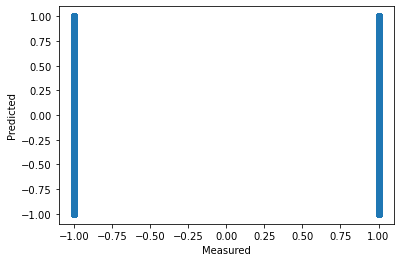

In [6]:
crossValidatedPredictionsRegressor(df_new)

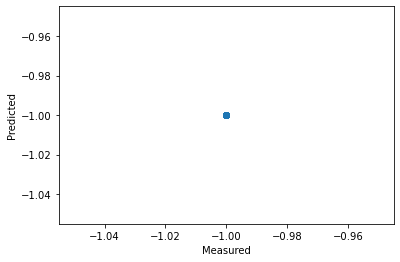

In [7]:
crossValidatedPredictionsRegressor(df_neg)

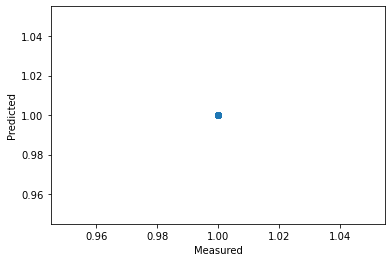

In [8]:
crossValidatedPredictionsRegressor(df_pos)

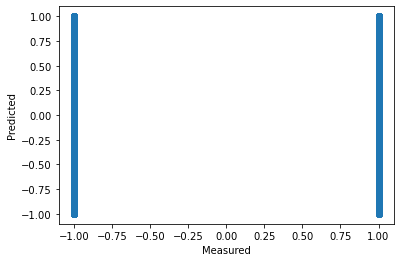

In [26]:
crossValidatedPredictionsRegressor(df_red)

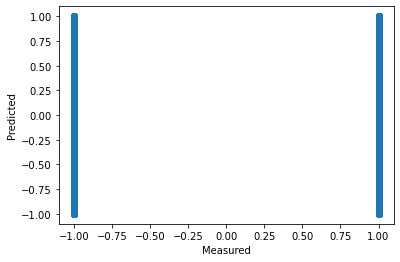

In [10]:
crossValidatedPredictionsRegressor(df_blue)

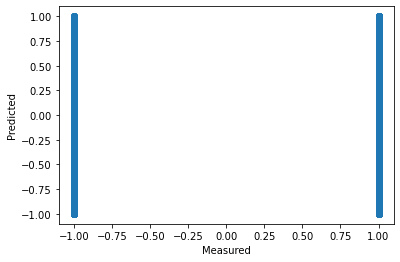

In [11]:
crossValidatedPredictionsRegressor(df_move)

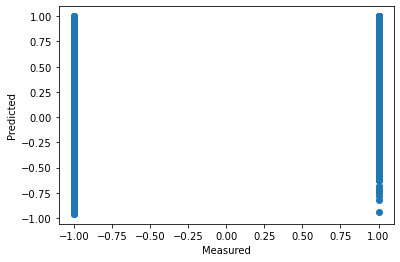

In [12]:
crossValidatedPredictionsRegressor(df_attack)

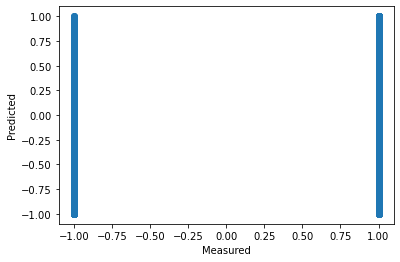

In [27]:
crossValidatedPredictionsRegressor(df_pass)

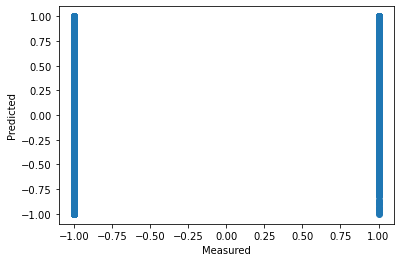

In [14]:
crossValidatedPredictionsRegressor(df_red_move)

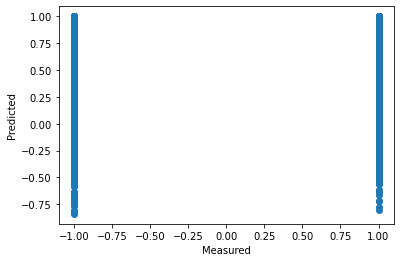

In [15]:
crossValidatedPredictionsRegressor(df_red_attack)

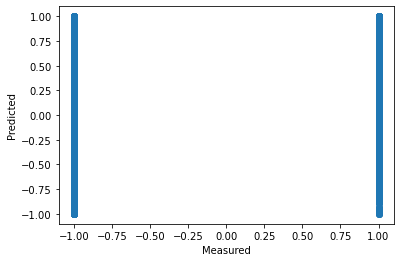

In [16]:
crossValidatedPredictionsRegressor(df_red_pass)

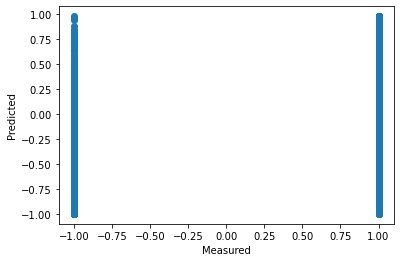

In [17]:
crossValidatedPredictionsRegressor(df_blue_move)

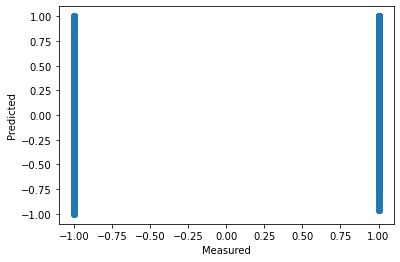

In [18]:
crossValidatedPredictionsRegressor(df_blue_attack)

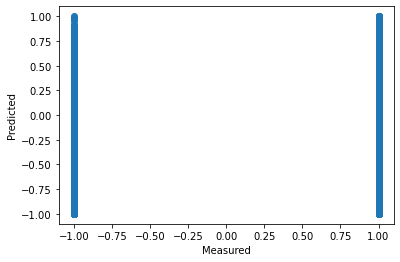

In [19]:
crossValidatedPredictionsRegressor(df_blue_pass)

In [20]:
def random_regressor(df):
    X = df.drop(['winner', 'label'], axis=1)
    y = df['label']
    train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = 42)
    regr = RandomForestRegressor()
    regr.fit(X, y)
    predictions = regr.predict(test_features)

    # Calculate the absolute errors
    errors = abs(predictions - test_labels)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2))
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / test_labels)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, predictions))
    print('Mean Squared Error:', metrics.mean_squared_error(test_labels, predictions))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, predictions)))


In [21]:
random_regressor(df_new)

Mean Absolute Error: 0.23 degrees.
Mean Absolute Error: 0.22933240611961056
Mean Squared Error: 0.08481655076495132
Root Mean Squared Error: 0.29123281196484596


In [22]:
random_regressor(df_red)

Mean Absolute Error: 0.11 degrees.
Mean Absolute Error: 0.11057399723374828
Mean Squared Error: 0.02990359612724758
Root Mean Squared Error: 0.17292656281568652


In [23]:
random_regressor(df_blue)

Mean Absolute Error: 0.12 degrees.
Mean Absolute Error: 0.12349528137015031
Mean Squared Error: 0.03491981824536875
Root Mean Squared Error: 0.18686845171234429


In [28]:
random_regressor(df_neg)

Mean Absolute Error: 0.0 degrees.
Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.0


In [29]:
random_regressor(df_pos)

Mean Absolute Error: 0.0 degrees.
Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.0


In [30]:
random_regressor(df_move)

Mean Absolute Error: 0.2 degrees.
Mean Absolute Error: 0.1996635120925342
Mean Squared Error: 0.07366603575184016
Root Mean Squared Error: 0.27141487754329197


In [31]:
random_regressor(df_attack)

Mean Absolute Error: 0.23 degrees.
Mean Absolute Error: 0.231959213401311
Mean Squared Error: 0.08397378004369992
Root Mean Squared Error: 0.2897822976713725


In [34]:
random_regressor(df_pass)

Mean Absolute Error: 0.26 degrees.
Mean Absolute Error: 0.2560290556900726
Mean Squared Error: 0.10088038740920097
Root Mean Squared Error: 0.3176167303672792


In [35]:
random_regressor(df_red_move)

Mean Absolute Error: 0.16 degrees.
Mean Absolute Error: 0.1565562913907285
Mean Squared Error: 0.05385324503311258
Root Mean Squared Error: 0.23206301952942132


In [36]:
random_regressor(df_red_attack)

Mean Absolute Error: 0.16 degrees.
Mean Absolute Error: 0.15764238410596026
Mean Squared Error: 0.054965298013245026
Root Mean Squared Error: 0.23444679143303504


In [37]:
random_regressor(df_pass)

Mean Absolute Error: 0.26 degrees.
Mean Absolute Error: 0.25606133979015333
Mean Squared Error: 0.10206489104116223
Root Mean Squared Error: 0.319475963166499


In [38]:
random_regressor(df_blue_move)

Mean Absolute Error: 0.17 degrees.
Mean Absolute Error: 0.16715995647442874
Mean Squared Error: 0.05953297062023939
Root Mean Squared Error: 0.24399379217561948


In [39]:
random_regressor(df_blue_attack)

Mean Absolute Error: 0.21 degrees.
Mean Absolute Error: 0.21252427184466016
Mean Squared Error: 0.0729663430420712
Root Mean Squared Error: 0.2701228295462477


In [40]:
random_regressor(df_blue_pass)

Mean Absolute Error: 0.17 degrees.
Mean Absolute Error: 0.1687547169811321
Mean Squared Error: 0.05831667924528302
Root Mean Squared Error: 0.24148846607091407


In [24]:
def random_forest(df):
    f_select=[]
   
    X = df.drop(['winner', 'label'], axis=1)
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    clf = RandomForestClassifier(n_estimators=100)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    proba = clf.predict_proba(X_test)
    proba = np.around(proba, decimals=2)
    print(y_train)  


    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

    # feature importanti per determinarlo
    feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print('Feature importance:\n', feature_imp)
    f_selection=feature_imp[(feature_imp>0)]
    print('Feature selection:\n',f_selection)
            
        
    # Creating a bar plot
    sns.barplot(x=f_selection, y=f_selection.index)
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.legend()
    plt.show()
    #return X_test, y_test, y_pred, proba


13   -1
1    -1
12    1
3     1
22    1
     ..
2    -1
21   -1
14   -1
27   -1
19    1
Name: label, Length: 16105, dtype: int64
[[2450  927]
 [ 771 2755]]
              precision    recall  f1-score   support

          -1       0.76      0.73      0.74      3377
           1       0.75      0.78      0.76      3526

    accuracy                           0.75      6903
   macro avg       0.75      0.75      0.75      6903
weighted avg       0.75      0.75      0.75      6903

Accuracy: 0.7540199913081269
Feature importance:
 blue_goal_GoalDefendPoint_score    0.032082
action_destination_x               0.019039
action_destination_z               0.016674
red_goal_GoalReachPoint_score      0.016542
blue_distance_2_1                  0.016101
                                     ...   
blue_figure_0_weapon_GR            0.000000
blue_figure_0_weapon_MT            0.000000
blue_figure_0_weapon_AT            0.000000
blue_figure_0_weapon_MG            0.000000
blue_figure_1_hp_max       

No handles with labels found to put in legend.


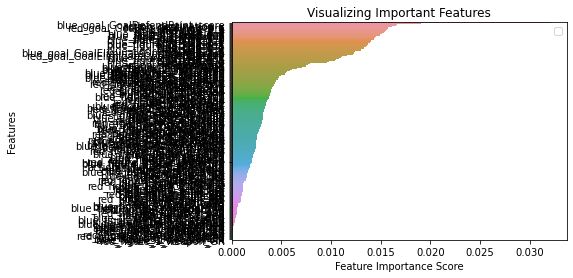

In [25]:
random_forest(df_new)